# CGM prediction tests #
Michael Strand / Chelsea Huynh


## Considerations: ##
    - We wish to predict glucose measurements using various combinations of monitoring readings.
        
    - Glucose measures are taken 24/7, every 5 minutes. Monitor readings are continuous each second, but 
        are turned off when the patient sleeps and back on when they awaken. If readings -> glucose then we
        need to take care in aligning monitoring data to measured glucose. This can be accomplished by trimming
        the monitored data at the start and end of the day, such that we have whole 5 minute intervals (in seconds).
    
    - Each patient and day will need to be cleaned differently, since measures begin and end arbitrarily. 
    
    - Several parameters have major effects on algorithm outcomes: 
        * Predicting features: the monitored data (Heart rate, Breathing rate, ECGWavelength, etc.)
            we will use to predict the glucose readings. It makes sense to include features related 
            to the heart, since the we mask according to "ECGNoise". 
        * Reading frequency (tau): To predict a glucose measure will take 5 minutes of monitored data.
            If we include all possible readings (1 per second) we will have an overdetermined system.
            Therefore, each minute choose only tau readings with the constraint tau|60. Different choices 
            of tau give different results.
        * Noise limit: Noise level at which we consider the data missing. Each second 'ECGNoise' is 
            quantified and we can mask a reading if this value is too large. This masking results in a
            missing tuple, since features are taken in groups. Thus, tuple length is the number of features.
            This also gives a natural interpretation for p, the probability of data being present.
            
     - The tuple structure induced by noise-masking appears i.i.d Bernoulli (see CGM 3).

First define $\ell$-tuple mSGD and SGD functions (nothing special).

In [1]:
import random

# ltuple mSGD functions

def ltuple_msgd(A_tilde, y, xls, maxiter, p, ell, alpha): 

    m = np.shape(A_tilde)[0]
    n = np.shape(A_tilde)[1]
    resid_err = np.zeros((maxiter))
    act_err = np.zeros((maxiter))
    xhat = np.zeros((n, 1))
    current_iter = 0
    approx_err = np.zeros((1, maxiter))
    
    # Create Matrix Q for the update function
    L_matrix = np.zeros((n,n))
    for i in range(0, n - (n % ell), ell):
        v = np.zeros((n))
        v[i:i + ell] = 1
        L_matrix = L_matrix + (np.outer(v,v))

    while current_iter < maxiter:
        
        i = random.randint(0,m-1)
        Ai_tilde = A_tilde[i,:]
        
        # split these since numpy is weird with matrix mults and we don't want any mistakes
        At = np.transpose(Ai_tilde)
        A1 = np.dot(Ai_tilde, xhat) - p*y[i]
        AA = (A1*At).reshape((n,1))
        BB = np.multiply(L_matrix, np.outer(Ai_tilde, Ai_tilde))
        CC = np.dot(BB, xhat)
        
        gxk = (1/p**2)*AA - ((1-p)/p**2)*CC
        xhat -= alpha*gxk
        
        y_e = np.linalg.norm(np.dot(A_tilde, xhat) - y)**2
        resid_err[current_iter] = y_e
        
        x_e = np.linalg.norm(xls - xhat)**2
        act_err[current_iter] = x_e
        
        current_iter += 1
            
    return resid_err, act_err

In [2]:
import random

# SGD function

def sgd(A_tilde, y, xls, maxiter, alpha): 

    m = np.shape(A_tilde)[0]
    n = np.shape(A_tilde)[1]
    resid_err = np.zeros((maxiter))
    act_err = np.zeros((maxiter))
    xhat = np.zeros((n, 1))
    current_iter = 0
    approx_err = np.zeros((1, maxiter))

    while current_iter < maxiter:
        
        i = random.randint(0,m-1)
        Ai_tilde = A_tilde[i,:]
        
        # split these since numpy is weird with matrix mults and we don't want any mistakes
        At = np.transpose(Ai_tilde)
        A1 = np.dot(Ai_tilde, xhat) - y[i]
        AA = (A1*At).reshape((n,1))
        
        gxk = AA
        xhat -= alpha*gxk
        
        y_e = np.linalg.norm(np.dot(A_tilde, xhat) - y)**2
        resid_err[current_iter] = y_e
        
        x_e = np.linalg.norm(xls - xhat)**2
        act_err[current_iter] = x_e
        
        current_iter += 1
            
    return resid_err, act_err

Import and prepare the raw Excel. Most of the cleaning can be automatically done by cgm_preds later.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# summary table 
raw_summary = pd.read_csv('2014_10_02-10_56_44_Summary.csv')
raw_summary = raw_summary.iloc[436:-424] # trim measurements that don't correspond to a prediction (5 minute interval)
raw_summary['Time'] = raw_summary['Time'].str[10:]
raw_summary['Time'] = raw_summary['Time'].str[:9]

noise = raw_summary[['ECGNoise']]

# junk variables (all constant)
raw_summary = raw_summary.drop('BRNoise', axis=1)
raw_summary = raw_summary.drop('BRConfidence', axis=1)
raw_summary = raw_summary.drop('GSR', axis=1)
raw_summary = raw_summary.drop('LinkQuality', axis=1)
raw_summary = raw_summary.drop('RSSI', axis=1)
raw_summary = raw_summary.drop('TxPower', axis=1)
raw_summary = raw_summary.drop('ECGNoise', axis=1)
raw_summary = raw_summary.drop('HRV', axis=1)

# HR != 0 in a living human
raw_summary['HR'] = raw_summary['HR'].mask(raw_summary['HR'] == 0).ffill()

# breathing table
raw_breathing = pd.read_csv('2014_10_02-10_56_44_Breathing.csv')
raw_breathing['Time'] = raw_breathing['Time'].str[10:]
raw_breathing_slim = raw_breathing.loc[(raw_breathing['Time']).str[-3:] == '420']
raw_breathing_slim['Time'] = raw_breathing_slim['Time'].str[:9]

# ecg table
raw_ecg = pd.read_csv('2014_10_02-10_56_44_ECG.csv')
raw_ecg['Time'] = raw_ecg['Time'].str[10:]
raw_ecg_slim = raw_ecg.loc[(raw_ecg['Time']).str[-3:] == '424']
raw_ecg_slim['Time'] = raw_ecg_slim['Time'].str[:9]

# trim glucose measures so we can properly shape our A matrix 
raw_glucose = pd.read_csv('glucose.csv')
raw_glucose_day1 = raw_glucose.loc[(raw_glucose['date']).str[-1] == '2']
raw_glucose_day1 = raw_glucose_day1.drop('comments', axis=1)

# start at 10:56
raw_glucose_day1_trim = raw_glucose_day1.iloc[135:-30]
raw_glucose_day1_trim['time'] = raw_glucose_day1_trim['time'].str[:5]

# drop manual imputations for conistancy 
raw_glucose_day1_trim = raw_glucose_day1_trim.loc[(raw_glucose_day1_trim['type']) == 'cgm']

C:\Users\mikew\AppData\Local\Temp/ipykernel_1136/1770268405.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_breathing_slim['Time'] = raw_breathing_slim['Time'].str[:9]
C:\Users\mikew\AppData\Local\Temp/ipykernel_1136/1770268405.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_ecg_slim['Time'] = raw_ecg_slim['Time'].str[:9]
C:\Users\mikew\AppData\Local\Temp/ipykernel_1136/1770268405.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [4]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# standardize, reshape, mask and then run comparison + plot according to parameters

def cgm_preds(raw_data, glucose_readings, noise, features: list, tau : int, maxiter : float, too_high_noise : float, sampling : str, metric : str):
    
    # raw_data: dataframe containing all features and raw measurements as read from csv (after trimming)
    # glucose_readings: dataframe of values to predict - this is y
    # noise: vector of noise measurement each second (for masking)
    # features: the predicting variables
    # tau: number of samples per minute we use to predict
    # maxiter: max iterations
    # too_high_noise: if noise(i) > too_high_noise, the tuple associated with time for noise(i) is masked with 0s
    # sampling: ('Random', 'Average', 'Constant') defines how rows of the raw data matrix are selected
    
    qualities_norm = raw_data.copy()
    y_glucose = pd.DataFrame(glucose_readings).to_numpy().reshape(-1,1) # correct form and shape for y vector
    qualities_norm = qualities_norm[features] # separate out desired features
    noise_vec = noise.to_numpy() # Used for the mask: len(qualities_norm) x 1 vector. Holds noise value each second
    
    glucose_measure_counts = len(glucose_readings) 
    ell = len(features) # tuple length = feature count
    m = glucose_measure_counts # number of rows    
    
    # take data in specified intervals (tau) and according to specific sampling method
    if sampling == 'Random':
        df_randsamp = pd.DataFrame()
        concat = qualities_norm.copy()
        concat['noise_ref'] = noise_vec
        
        for i in range(len(qualities_norm)//60):
            df_randsamp = df_randsamp.append(concat.iloc[60*i:60*(i+1), :].sample(tau))  
        noise_vec = df_randsamp['noise_ref']
        df_randsamp.pop('noise_ref')
        qualities_norm = df_randsamp
        
    elif sampling == 'Average':   
        df_avg = pd.DataFrame()
        concat = qualities_norm.copy()
        concat['noise_ref'] = noise_vec
        
        for i in range(len(qualities_norm)//60):
            df_avg = df_avg.append(pd.DataFrame(concat.iloc[60*i:60*(i+1), :].mean(axis=0).to_numpy().reshape((1,-1))))
        noise_vec = df_avg.pop(2).to_numpy()
        qualities_norm = df_avg
        
    elif sampling == 'Constant':
        qualities_norm = pd.DataFrame(qualities_norm).iloc[::60//tau, :].to_numpy() # choose every 60/tau'th row 
        noise_vec = pd.DataFrame(noise_vec).iloc[::60//tau, :].to_numpy()    
    else:
        return None
        
    # standardize (check for normalcy)
    scaler = StandardScaler(copy = True)
    qualities_norm = scaler.fit_transform(qualities_norm)
    y_glucose_norm = scaler.fit_transform(y_glucose)            
        
    # masking by noise
    mask = np.ones((qualities_norm.shape[0],qualities_norm.shape[1]))
    A_norm_mask = qualities_norm.copy()
    A_norm_mask_plot = qualities_norm.copy() # for heatmap tuple dist plot

    index = 0
    zeros = 0
    
    # generate mask - add in 0s if noise too high    
    for i in range(len(noise_vec)):
        if noise_vec[index] > too_high_noise:
            zeros += ell
            A_norm_mask[i, :] = 0
            A_norm_mask_plot[i, :] = -100
        index += 1

    p = 1 - zeros/(A_norm_mask.size) # estimate for probability data present

    # reshape (glucose readings x 5 * features * frequency = m x n)
    A_norm_mask = np.reshape(A_norm_mask, (-1)) # flatten
    A_norm_mask = np.reshape(A_norm_mask, (m,-1)) # reshape - each row corresponds to 5*60 seconds (in tau intervals) of readings
    A_norm_mask_plot = np.reshape(A_norm_mask_plot, (m, -1))
    A_unmasked = np.reshape(qualities_norm, (m,-1))
    
    # least squares
    A_pinv = np.linalg.pinv(A_unmasked)
    xls = np.dot(A_pinv,y_glucose_norm)
    
    # Plotting
    print('p:', p)
    print('A dimension:', A_norm_mask.shape)
    print('features (tuple length):', ell)

    fig, axes = plt.subplots(2, 4, figsize=(13, 7))
    fig.tight_layout(pad = 5)

    # plot tuple distribution
    plt.subplot(2, 4, 1)   
    sns.heatmap(A_norm_mask_plot, annot=False)
    plt.title('tuple distribution')
    
    for i in range(1, 8):
        alpha = 10**(-(0.5*i + 2))

        [lrerr, laerr] = ltuple_msgd(A_norm_mask, y_glucose_norm, xls, maxiter, p, ell, alpha)
        [rerr, aerr] = sgd(A_unmasked, y_glucose_norm, xls, maxiter, alpha)
        plt.subplot(2, 4, i+1)
        
        if metric == 'Actual':
            plt.plot(laerr)
            plt.plot(aerr, '--') 
            plt.ylabel('Actual')
        if metric == 'Residual':
            plt.plot(lrerr)
            plt.plot(rerr, '--')
            plt.ylabel('Residual')
            
        plt.title("alpha: {0:.6f}".format(alpha), loc = 'right')
    
    plt.legend(['ltuple mSGD - masked', 'SGD - unmasked'], loc = 'lower left')    
    plt.show()
    
    return None

p: 0.9
A dimension: (126, 10)
features (tuple length): 2


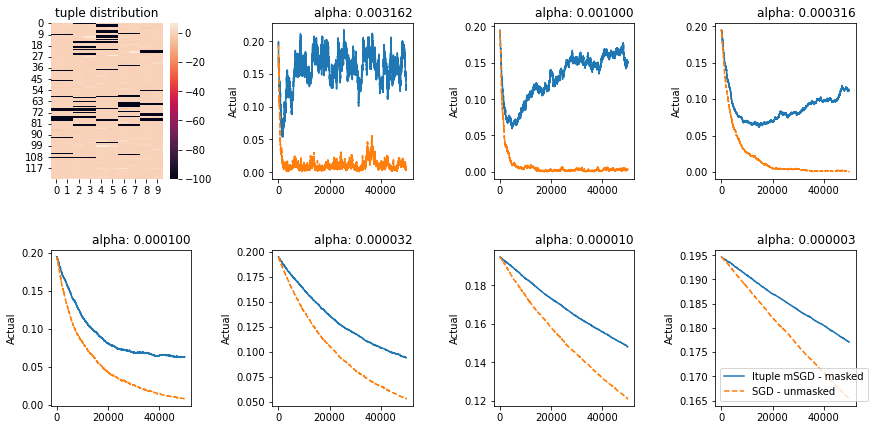

In [14]:
qualities = pd.concat([raw_summary.set_index('Time'), 
                       raw_breathing_slim.set_index('Time'), 
                       raw_ecg_slim.set_index('Time')],
                axis=1, join='inner') # note the inner join forces ecg/breathing tables to have the same trimmed times

features = ['EcgWaveform', 'ECGAmplitude'] # good predictors of glucose according to paper
tau = 1
too_high_noise = 0.00085
maxiter = 50000
sampling = 'Random'
metric = 'Actual' 

cgm_preds(qualities, raw_glucose_day1_trim['glucose'], features = features, noise = noise, tau = tau, 
          too_high_noise = too_high_noise, maxiter = maxiter, sampling = sampling, metric = metric)